In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

from scipy.spatial import procrustes

In [2]:
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/lrma_pilot"

dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
respkl   = os.path.join("../dsc/results", dsc_fname + ".pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")

if os.path.isfile(dscoutpkl):
    dscout = pd.read_pickle(dscoutpkl)
else:
    print ("Could not find dscout from dscquery")

refresh_pickle = True
sim_module = "blockdiag"
target = [sim_module] + [f"{sim_module}.{prop}" for prop in ["p", "k", "h2", "h2_shared_frac", "aq", "a0"]]

condition = [""]

print ("Reading from DSC database:")
print (f"    {db}")
print ("")

qp = dscQP(db, target, condition)
df = qp.output_table

df

Could not find dscout from dscquery
Reading from DSC database:
    /gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/lrma_pilot/lrma_pilot.db



,DSC,blockdiag.output.file,blockdiag.p,blockdiag.k,blockdiag.h2,blockdiag.h2_shared_frac,blockdiag.aq,blockdiag.a0
0,1,blockdiag/blockdiag_1,500,10,0.2,0.5,0.6,0.2


In [3]:
df.iloc[[0]]

,DSC,blockdiag.output.file,blockdiag.p,blockdiag.k,blockdiag.h2,blockdiag.h2_shared_frac,blockdiag.aq,blockdiag.a0
0,1,blockdiag/blockdiag_1,500,10,0.2,0.5,0.6,0.2


In [4]:
#fprefix = df.loc[df['DSC'] == 2]['blockdiag_p.output.file'].values[0]
fprefix = df.iloc[[0]][f'{sim_module}.output.file'].values[0]
fname = os.path.join(dsc_output, f"{fprefix}.pkl")
data  = dsc_io.load_dsc(fname)

In [5]:
Z = data['Z']
Z_cent = Z - np.mean(Z, axis = 0, keepdims = True)
labels = np.array(data['Ctrue'])

In [6]:
data.keys()

dict_keys(['Z', 'Zmask', 'effect_size_obs', 'effect_size_true', 'Ltrue', 'Ftrue', 'Mtrue', 'Ctrue', 'nsample', 'DSC_DEBUG'])

In [14]:
import scipy.stats as sc_stats
import sys
sys.path.append("/gpfs/commons/home/sbanerjee/work/npd/npd-notes/notebooks/utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

def q1(x, axis = None):
    return np.percentile(x, 25, axis = axis)

def q3(x, axis = None):
    return np.percentile(x, 75, axis = axis)

def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

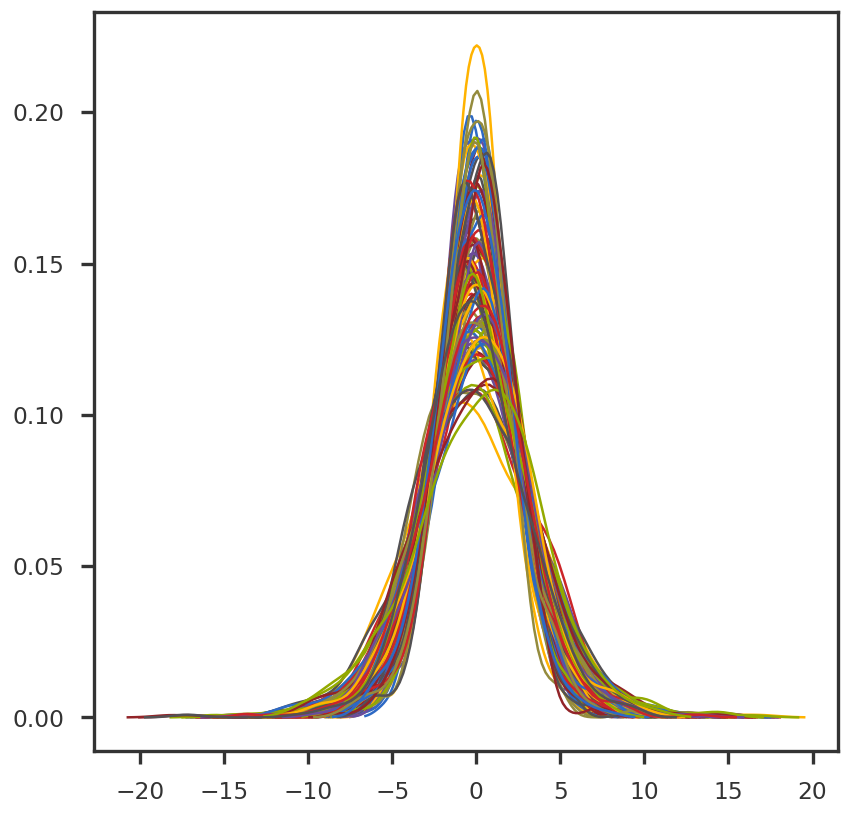

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for n in range(100):
    #scores = Z[n, :]
    #scores_cent = scores / np.std(scores)
    #scores_cent = scores - np.mean(scores)
    scores_cent = Z_cent[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, None, None)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)

plt.show()

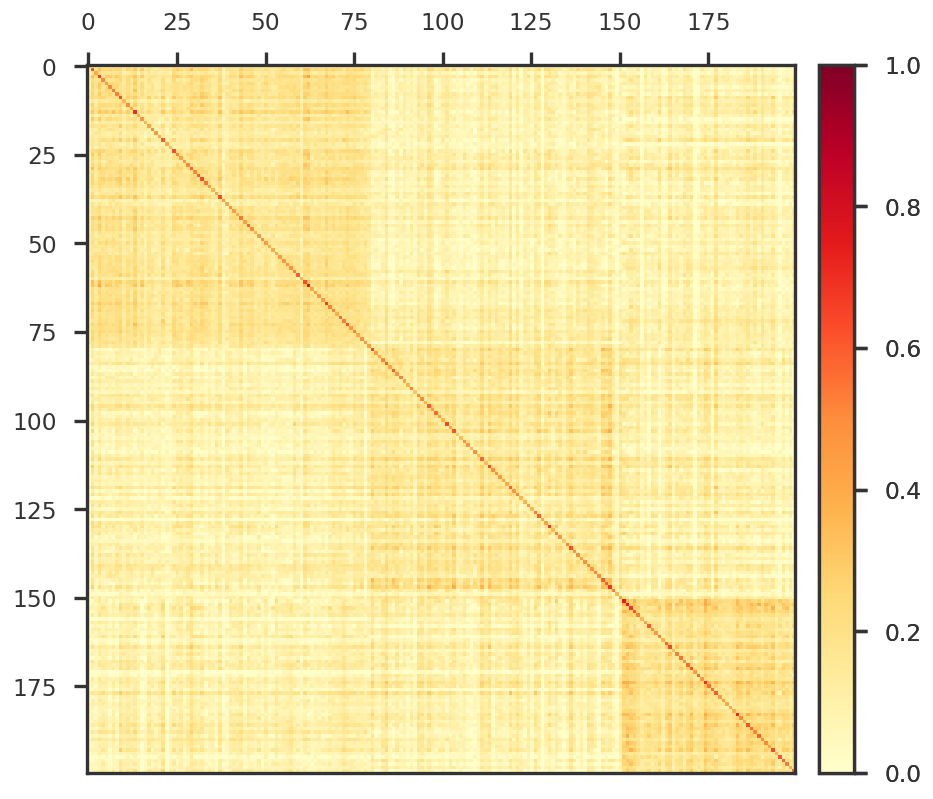

In [24]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(1000) / np.sqrt(10000))
# mpy_plotfn.plot_covariance_heatmap(ax1, data['Ltrue'] * np.sqrt(100))
# mpy_plotfn.plot_covariance_heatmap(ax1, data['effect_size_obs'] * np.sqrt(1000))

plt.tight_layout()
plt.show()

In [10]:
from clorinn.optimize import FrankWolfe, FrankWolfe_CV

def do_center_nan(X):
    ''' 
    X may contain NaN values
    '''
    X_mask = np.isnan(X)
    X_cent = X - np.nanmean(X, axis = 0, keepdims = True)
    X_cent = np.nan_to_num(X_cent, copy = True, nan = 0.0)
    return X_cent, X_mask

def class_to_dict(classname, property_list = None):
    model = dict()
    if property_list is None:
        property_list = [ x for x in vars(classname).keys() if x not in ["logger_"] ]
    for info in property_list:
        model[info] = getattr(classname, info)
    return model

Z_cent, Z_mask  = do_center_nan(Z)
nnmcv_sparse = FrankWolfe_CV(kfolds = 2, debug = False, model = 'nnm-sparse',)
nnmcv_sparse.fit(Z_cent)
rank_opt = nnmcv_sparse._optimized_rank()

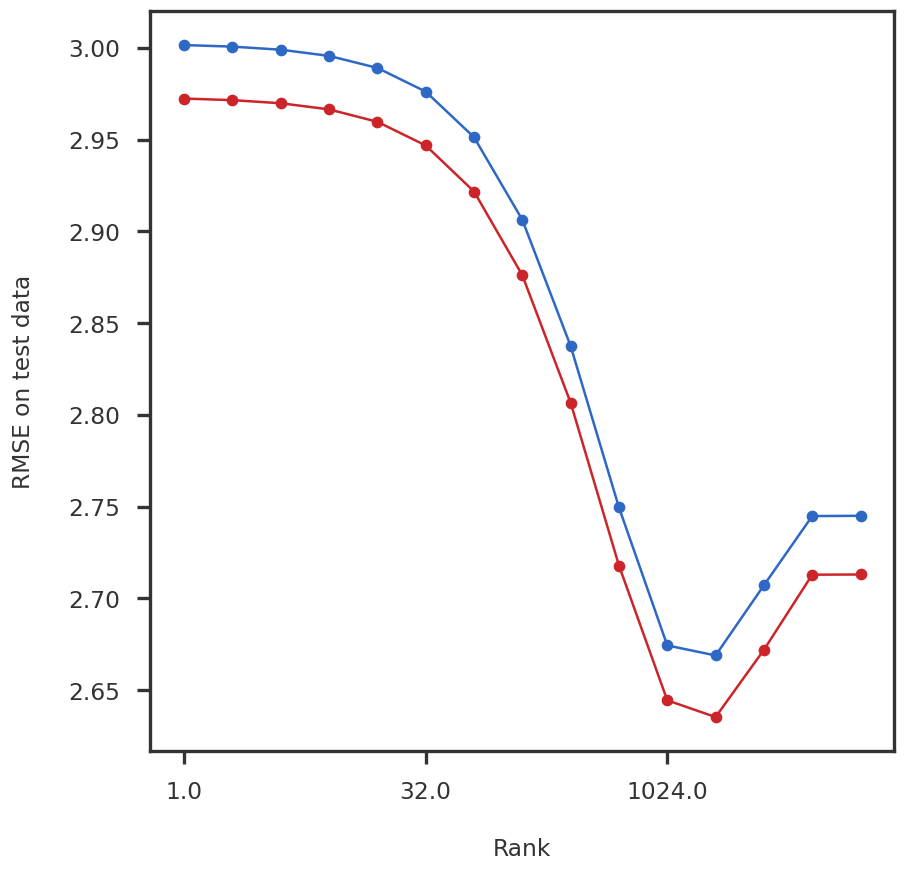

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(2):
    ax1.plot(np.log10(list(nnmcv_sparse.test_error.keys())), [x[k] for x in nnmcv_sparse.test_error.values()], 'o-')
ax1.set_xlabel("Rank")
ax1.set_ylabel("RMSE on test data")
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [12]:
lmb_opt = 1
nnm_sparse = FrankWolfe(model = 'nnm-sparse', svd_max_iter = 50, show_progress = True, debug = True)
nnm_sparse.fit(Z_cent, (1024.0, lmb_opt))

2025-12-11 15:01:09,299 | clorinn.optimize.frankwolfe              | INFO    | Iteration 0. Step size 0.291. Duality Gap 304812


INFO: Iteration 0. Step size 0.291. Duality Gap 304812


2025-12-11 15:01:11,025 | clorinn.optimize.frankwolfe              | INFO    | Iteration 100. Step size 0.010. Duality Gap 8900.22


INFO: Iteration 100. Step size 0.010. Duality Gap 8900.22


2025-12-11 15:01:12,733 | clorinn.optimize.frankwolfe              | INFO    | Iteration 200. Step size 0.004. Duality Gap 3807.93


INFO: Iteration 200. Step size 0.004. Duality Gap 3807.93


2025-12-11 15:01:14,451 | clorinn.optimize.frankwolfe              | INFO    | Iteration 300. Step size 0.002. Duality Gap 2156.24


INFO: Iteration 300. Step size 0.002. Duality Gap 2156.24


2025-12-11 15:01:16,156 | clorinn.optimize.frankwolfe              | INFO    | Iteration 400. Step size 0.003. Duality Gap 2168.15


INFO: Iteration 400. Step size 0.003. Duality Gap 2168.15


2025-12-11 15:01:17,603 | clorinn.optimize.frankwolfe              | INFO    | Iteration 485. Step size 0.001. Duality Gap 965.714


INFO: Iteration 485. Step size 0.001. Duality Gap 965.714


2025-12-11 15:01:17,605 | clorinn.optimize.frankwolfe              | INFO    | Step size converged below tolerance.


INFO: Step size converged below tolerance.


In [18]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_nnm_sparse, pcomps_nnm_sparse = get_principal_components(nnm_sparse.X)
_, Lfit_nnm_sparse, err_nnm_sparse = procrustes(pcomps_nnm_sparse[:, :10], data['Ltrue'])
print (f"Error = {err_nnm_sparse:g}")

Error = 0.13017


In [17]:
data['Ltrue'].shape

(200, 10)

In [28]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

tsvd = TruncatedSVD(n_components=100, n_iter=20)
US = tsvd.fit_transform(csr_matrix(Z_cent))
U = US / tsvd.singular_values_
Vt = tsvd.components_
S = tsvd.singular_values_

TruncatedSVD(n_components=100, n_iter=20)

In [ ]:
US = matt.fit_transform(csr_matrix(dat))
        U = US / (matt.singular_values_)
        V = (matt.components_).T
        D = matt.singular_values_

In [29]:
tsvd.singular_values_

array([523.76174135, 478.42270838, 129.86864114, 128.7477417 ,
       124.42548849, 123.86433604, 122.47971214, 121.25179424,
       120.78896342, 119.35588175, 118.41118836, 117.71077598,
       117.2839875 , 115.29718915, 114.66532302, 113.98733369,
       113.38070223, 111.70883474, 110.95116849, 109.34802798,
       108.82512737, 108.32480764, 107.82864926, 107.23171614,
       106.6544832 , 106.37270309, 106.06555926, 105.57581546,
       103.77259915, 103.75167348, 103.29065125, 102.6354923 ,
       101.82183877, 101.16068956, 100.37421461,  99.80464804,
        99.04380534,  98.38722437,  97.55472332,  97.16211401,
        96.4482293 ,  95.74889717,  94.37357425,  94.10069755,
        93.86324669,  93.19965932,  92.22189083,  91.92027939,
        91.29466351,  90.94113825,  90.24889062,  89.65475568,
        89.43612282,  88.57604238,  88.20374618,  87.7108814 ,
        87.08490143,  86.35675941,  85.6042198 ,  84.76660883,
        84.38408074,  84.05240442,  83.13950958,  83.04

In [11]:
np.linalg.norm(nnmcv_sparse.cvmodels[8192][0].M_, ord = 1)

1.3005777567431762

In [12]:
np.linalg.norm(nnmcv_sparse.cvmodels[32768][0].M_, ord = 1)

1.3406691472482515

In [13]:
np.linalg.norm(Z_cent, ord = 1) / np.sqrt(np.max(Z_cent.shape))

45.99713100167578

In [14]:
np.linalg.norm(data['Mtrue'], ord = 1)

6.594200498114851

In [39]:
data['Mtrue']

array([[-1.52498065e-02, -1.50236959e-02, -3.24440065e-03, ...,
        -5.66308676e-03,  1.61736546e-02,  2.59417493e-02],
       [ 8.46121805e-03,  5.66874428e-03,  1.64807835e-02, ...,
        -4.71848329e-03, -1.22234477e-03, -6.42782307e-03],
       [-8.37636975e-02,  4.98521459e-03,  8.94776601e-03, ...,
         1.29273882e-02, -1.56914471e-02, -6.51497645e-03],
       ...,
       [-9.86862993e-03, -8.20263036e-04, -8.94435624e-03, ...,
         1.36895992e-02, -3.15269371e-05,  1.26677686e-03],
       [ 2.07925331e-03, -1.30244812e-02, -1.63951904e-03, ...,
         8.38032787e-03,  3.94789569e-03,  1.08133895e-02],
       [-3.55061851e-02, -7.63921320e-03,  8.77522116e-03, ...,
        -6.45624928e-04, -9.15528497e-03,  9.85888721e-03]])

In [15]:
nnmcv_sparse.cvmodels[8192][0].l1_thres_

10.379434181017047

In [45]:
from nnwmf.optimize import IALM
rpca = IALM(max_iter = 1000, mu_update_method='admm', show_progress = False)
rpca.fit(Z_cent)

In [80]:
from nnwmf.utils import model_errors as merr

def _generate_fold_labels(Y, kfolds = 5, shuffle = True, test_size = None):
    n, p = Y.shape
    fold_labels = np.ones(n * p)
    if test_size is None:
        ntest = int ((n * p) / kfolds)
    else:
        ntest = int(test_size * n * p)
    for k in range(1, kfolds):
        start = k * ntest
        end = (k + 1) * ntest
        fold_labels[start: end] = k + 1
    if shuffle:
        np.random.shuffle(fold_labels)
    return fold_labels.reshape(n, p)


def _generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

def _generate_rseq(r_min = None, r_max = None, nseq = None):
    a_min = 0 if r_min is None else int(np.floor(np.log2(r_min)))
    a_max = max(0, a_min + 1) if r_max is None else int(np.floor(np.log2(r_max)) + 1)
    if nseq is None:
        nseq  = a_max - a_min + 1
    rseq = np.logspace(a_min, a_max, num = nseq, base = 2.0)
    return rseq

In [82]:
lmb_values = _generate_rseq(0.015, 0.05, nseq = 10)
kfolds = 2

test_errors =  {r: list() for r in lmb_values}
train_errors = {r: list() for r in lmb_values}
rpca_models  = {r: list() for r in lmb_values}

fold_labels = _generate_fold_labels(Z_cent, kfolds = kfolds)
for k in range(kfolds):
    print (f"Fold {k + 1}")
    mask = fold_labels == k + 1
    Ymiss = _generate_masked_input(Z_cent, mask)
    for lmb in lmb_values:
        rpca_cv = IALM(mu_update_method='admm', show_progress = False, debug = True, max_iter = 100)
        rpca_cv.fit(Ymiss, lmb = lmb, mask = mask)
        rpca_models[lmb].append(rpca_cv)
        recovered = mpy_simulate.do_standardize(rpca_cv.L_, scale = False)
        train_err_k  = merr.get(Z_cent, recovered, mask, method = 'rmse')
        test_err_k = merr.get(Z_cent, recovered, ~mask, method = 'rmse')
        train_errors[lmb].append(train_err_k)
        test_errors[lmb].append(test_err_k)

Fold 1
2024-01-14 16:08:01,032 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0078)
2024-01-14 16:08:19,266 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0098)
2024-01-14 16:08:36,512 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0124)
2024-01-14 16:09:03,303 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0156)
2024-01-14 16:09:33,317 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0197)
2024-01-14 16:10:05,829 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0248)
2024-01-14 16:10:39,354 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0312)
2024-01-14 16:11:15,856 | nnwmf.optimize.inexact_alm               | 

In [84]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    return pcomps

def get_adjusted_MI_score(x, class_labels):
    pcomp = get_principal_components(x)
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

adj_mi_scores = {r: list() for r in lmb_values}
recovered_matrix_ranks = {r: list() for r in lmb_values}
for k in range(kfolds):
    for lmb in lmb_values:
        mask = fold_labels == k + 1
        adj_mi_scores[lmb].append(get_adjusted_MI_score(rpca_models[lmb][k].L_, labels))
        recovered_matrix_ranks[lmb].append(np.linalg.matrix_rank(rpca_models[lmb][k].L_))

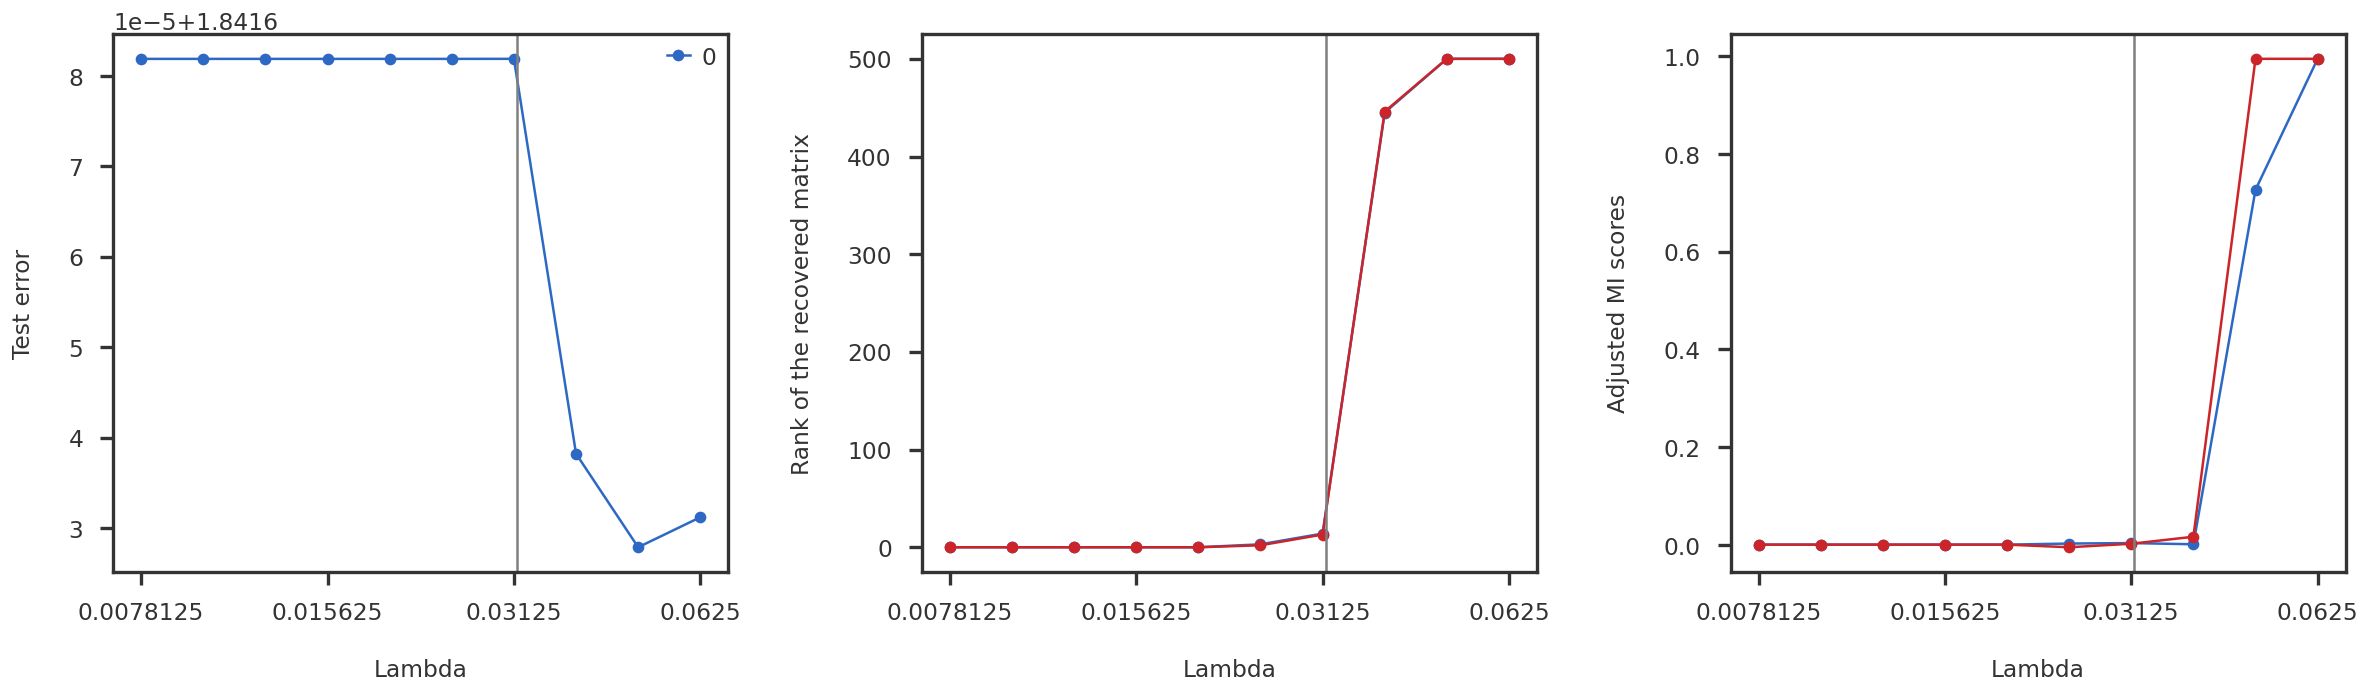

In [96]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131)
for k in range(1):
    ax1.plot(np.log2(lmb_values), [x[k] for x in train_errors.values()], 'o-', label = k)
ax1.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax1.legend()
ax1.set_ylabel("Test error")
ax1.set_xlabel("Lambda")

ax2 = fig.add_subplot(132)
for k in range(kfolds):
    ax2.plot(np.log2(lmb_values), [x[k] for x in recovered_matrix_ranks.values()], 'o-')
ax2.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax2.set_ylabel("Rank of the recovered matrix")
ax2.set_xlabel("Lambda")

ax3 = fig.add_subplot(133)
for k in range(kfolds):
    ax3.plot(np.log2(lmb_values), [x[k] for x in adj_mi_scores.values()], 'o-')
ax3.axvline(x = np.log2(1. / np.sqrt(np.max(Z.shape))), color = 'grey')
ax3.set_ylabel("Adjusted MI scores")
ax3.set_xlabel("Lambda")

for ax in [ax1, ax2, ax3]:
    mpl_utils.set_xticks(ax, scale = 'log2', spacing = 'log2')

plt.tight_layout(w_pad = 2.0)
plt.show()

In [48]:
from scipy.spatial import procrustes

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_rpca, pcomps_rpca = get_principal_components(rpca.L_)
_, Lfit_rpca, err_rpca = procrustes(pcomps_rpca[:, :100], data['Ltrue'])
print (f"Error = {err_rpca:g}")

Error = 0.0717543


In [49]:
np.linalg.norm(rpca.L_, ord = 'nuc')

8603.595018920805

In [56]:
np.linalg.norm(rpca.E_, ord = 1) / Z_cent.shape[0]

0.679462510919523

(500, 1000)

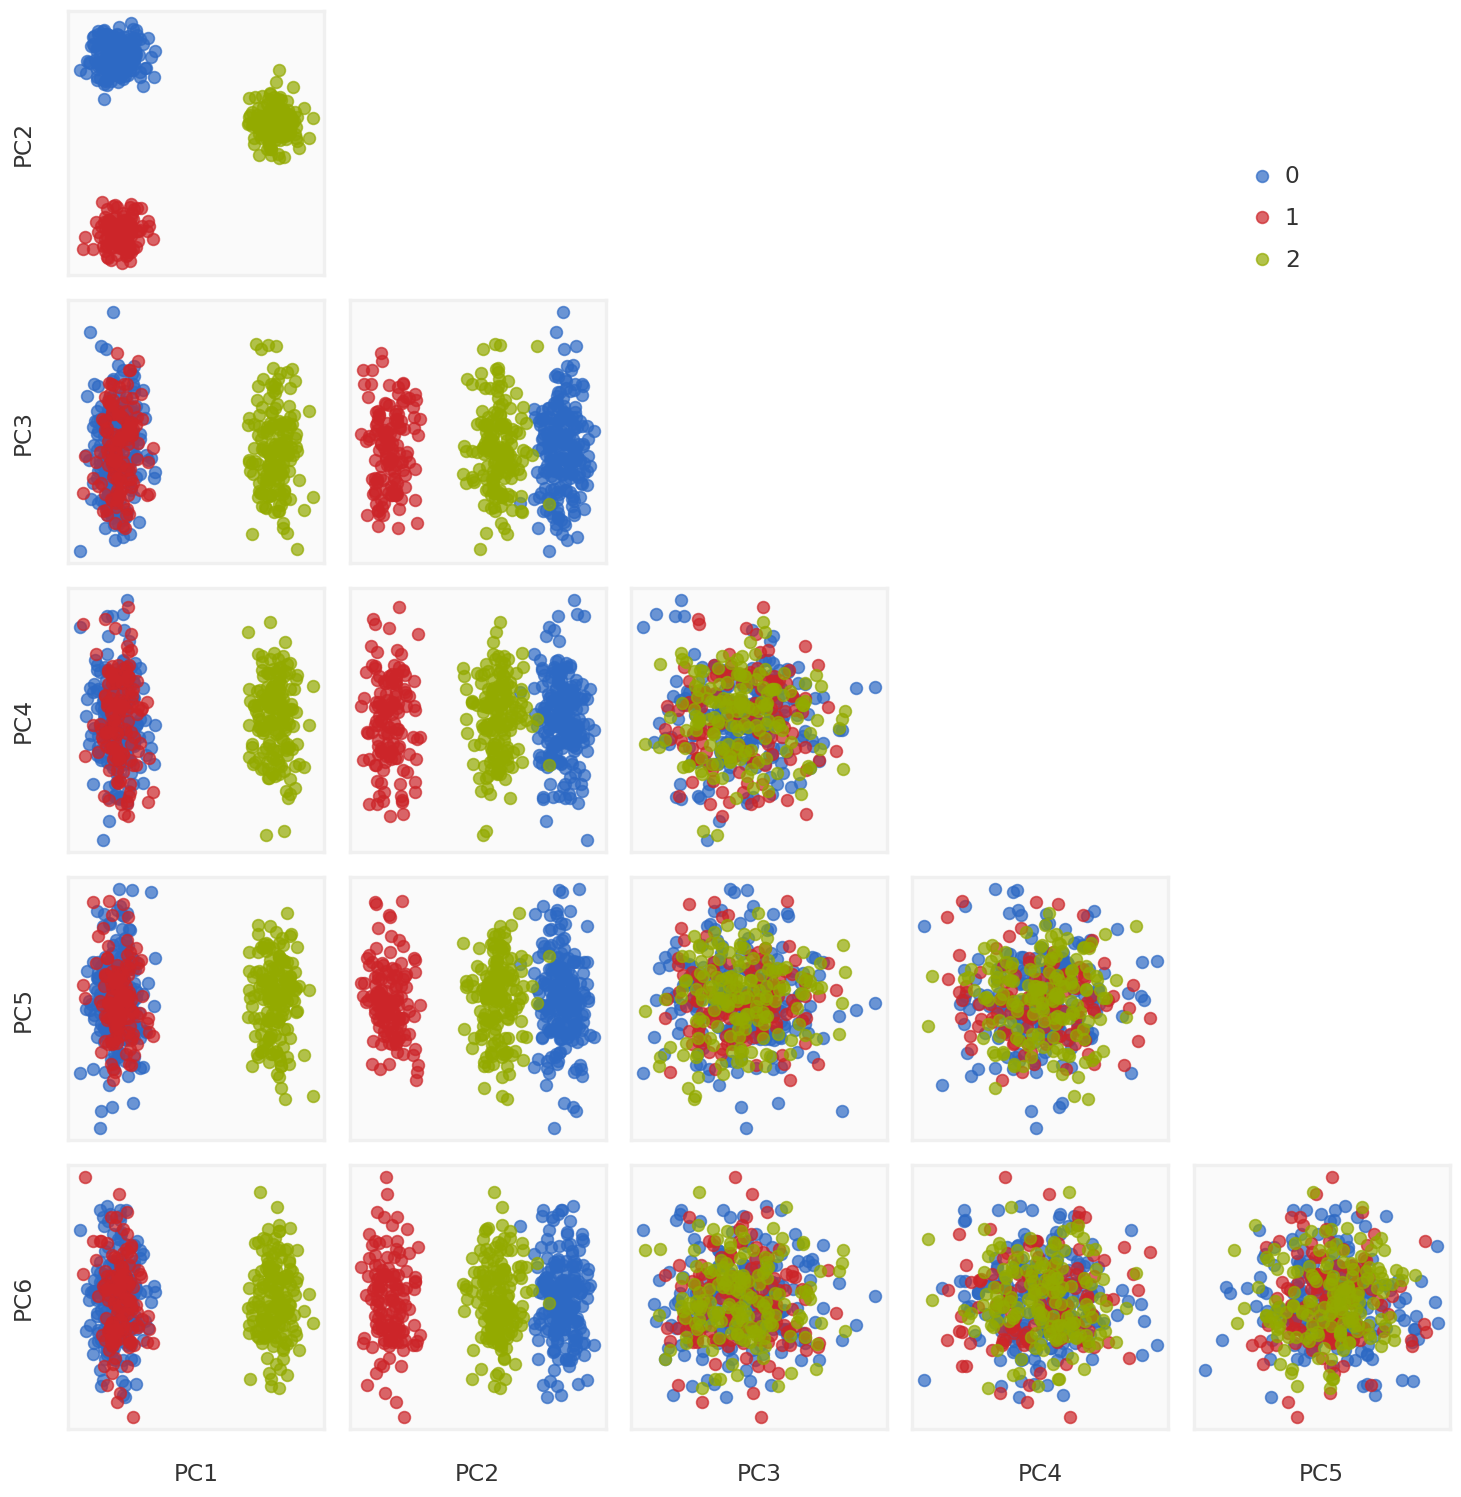

In [47]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca[:, :100], labels, list(set(labels)))
plt.show()

In [30]:
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV

def do_center_nan(X):
    ''' 
    X may contain NaN values
    '''
    X_mask = np.isnan(X)
    X_cent = X - np.nanmean(X, axis = 0, keepdims = True)
    X_cent = np.nan_to_num(X_cent, copy = True, nan = 0.0)
    return X_cent, X_mask

def class_to_dict(classname, property_list = None):
    model = dict()
    if property_list is None:
        property_list = [ x for x in vars(classname).keys() if x not in ["logger_"] ]
    for info in property_list:
        model[info] = getattr(classname, info)
    return model

Z_cent, Z_mask  = do_center_nan(Z)
nnmcv = FrankWolfe_CV(kfolds = 2, debug = True)
nnmcv.fit(Z_cent)
rank_opt = nnmcv._optimized_rank()

2024-01-15 15:09:02,228 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Cross-validation over 16 ranks.
2024-01-15 15:09:02,252 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 1 ...
2024-01-15 15:09:02,275 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 1.0000
2024-01-15 15:09:03,009 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 2.0000
2024-01-15 15:09:04,590 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 4.0000
2024-01-15 15:09:05,705 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 8.0000
2024-01-15 15:09:07,355 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 16.0000
2024-01-15 15:09:08,745 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 32.0000
2024-01-15 15:09:17,119 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 64.0000
2024-01-15 15:09:21,609 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Rank 128.0000
2024-01-15 15:09:23,113 | nnwmf.optimize.frankwolfe_cv            

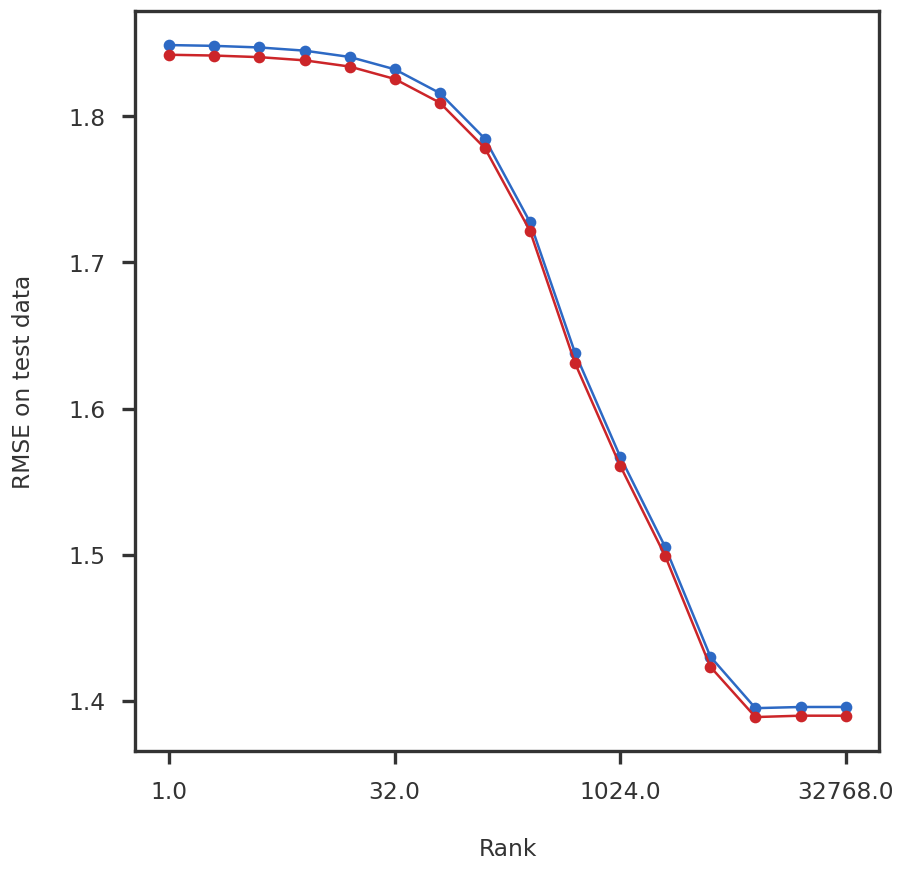

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(2):
    ax1.plot(np.log10(list(nnmcv.test_error.keys())), [x[k] for x in nnmcv.test_error.values()], 'o-')
ax1.set_xlabel("Rank")
ax1.set_ylabel("RMSE on test data")
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [33]:
nnm = FrankWolfe(model = 'nnm', max_iter = 10000, svd_max_iter = 50, show_progress = True)
nnm.fit(Z_cent, rank_opt)
nnm_dict = class_to_dict(nnm)

2024-01-15 15:11:24,171 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.064. Duality Gap 4.29066e+06


INFO: Iteration 0. Step size 0.064. Duality Gap 4.29066e+06


In [37]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps

loadings_nnm, pcomps_nnm = get_principal_components(nnm.X)
Ltrue_std, Lfit, err_nnm = procrustes(pcomps_nnm[:, :100], data['Ltrue'])
print (f"Error = {err_nnm:g}")

Error = 0.05893


In [44]:
np.linalg.norm(np.ones((10, 1000)), ord = 1)

10.0

In [187]:
rank_opt = nnmcv._optimized_rank()
lmb_opt  = 0.5

In [188]:
rank_opt

8192.0

In [189]:
lmb_opt

0.022360679774997897

In [190]:
nnm_sparse = FrankWolfe(model = 'nnm-sparse', svd_max_iter = 50, show_progress = True, debug = False)
nnm_sparse.fit(Z_cent, (rank_opt, lmb_opt))

In [191]:
loadings_nnm, pcomps_nnm = get_principal_components(nnm_sparse.X)
Ltrue_std, Lfit, err_nnm = procrustes(pcomps_nnm[:, :100], data['Ltrue'])

In [192]:
err_nnm

0.07069008057329933

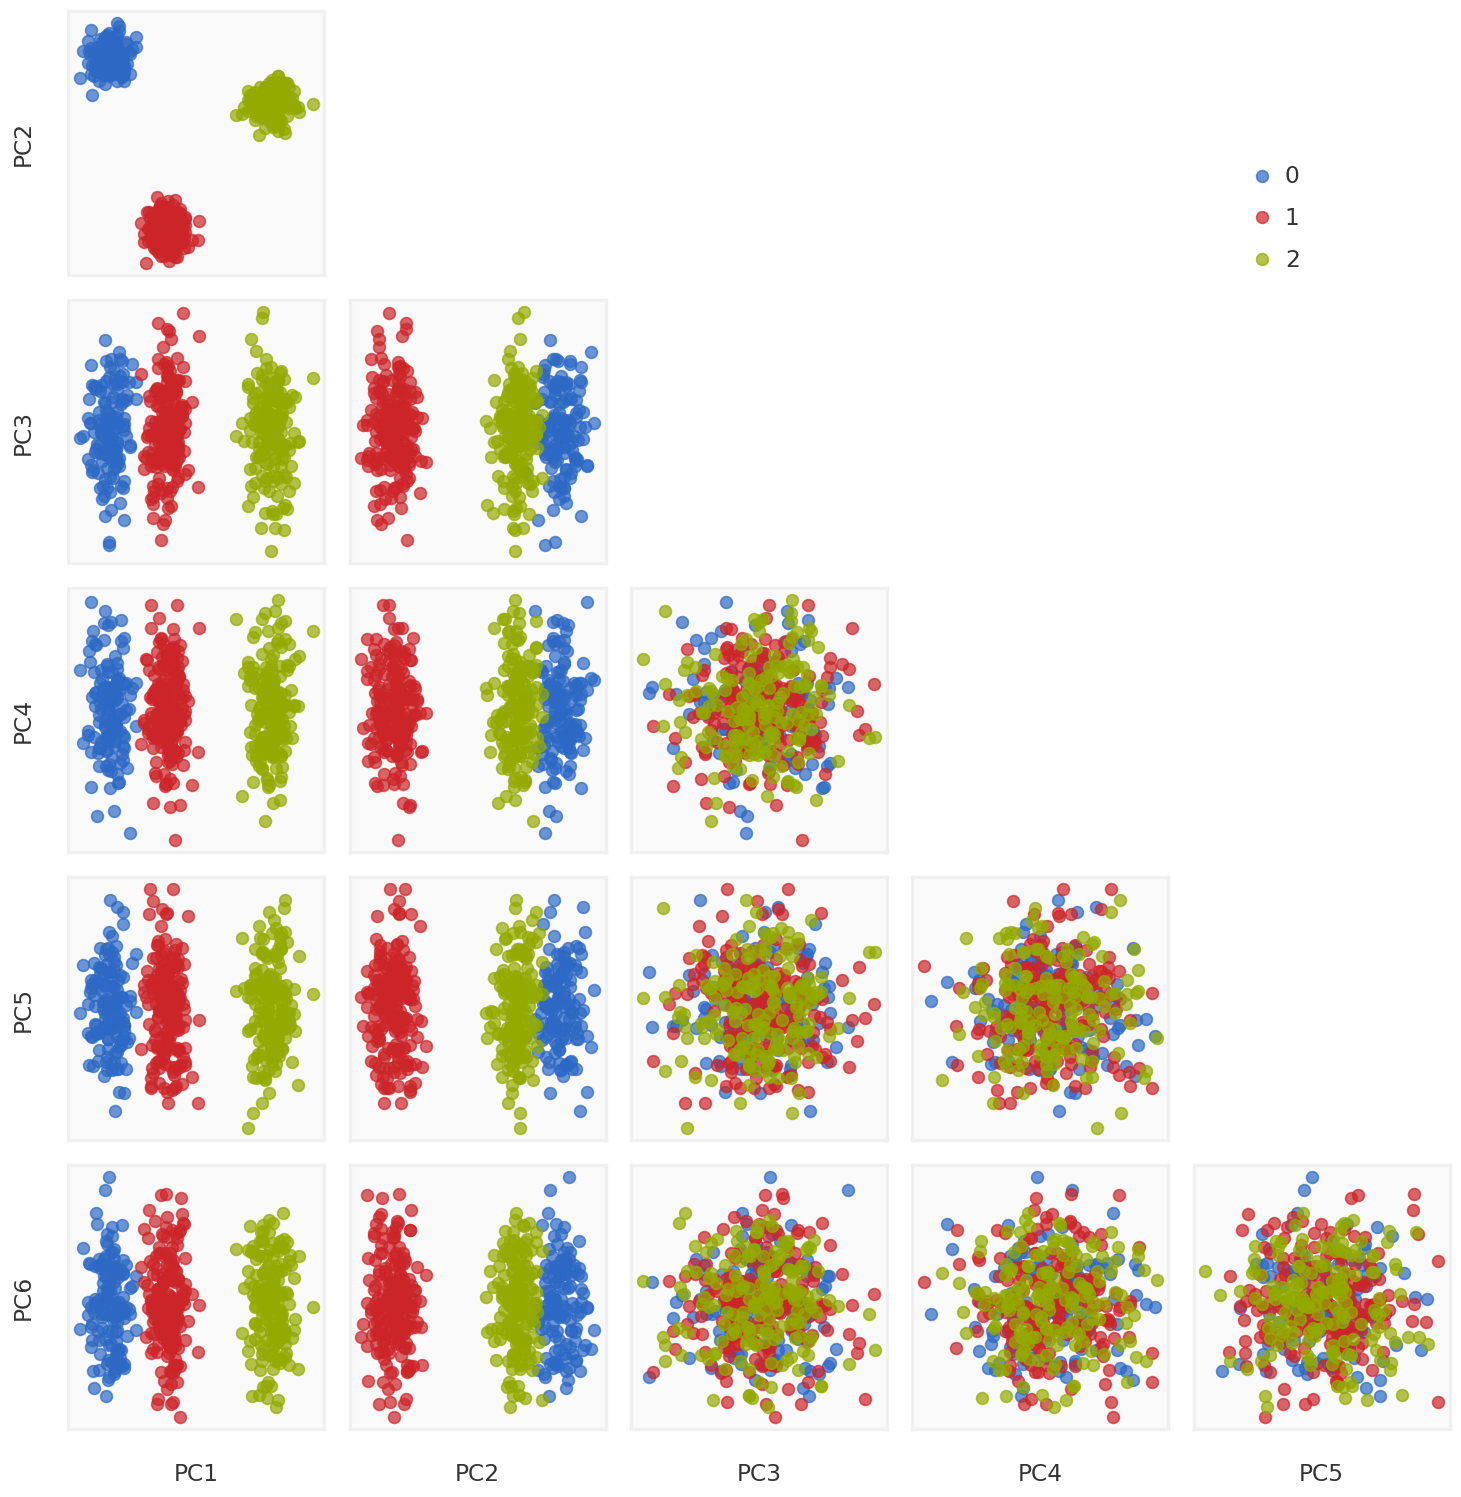

In [193]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm[:, :100], labels, list(set(labels)))
plt.show()

In [185]:
nnm.X

array([[ 1.02344971,  0.78854623, -0.18529542, ..., -0.4533087 ,
        -0.14311412, -0.88063497],
       [ 1.04563834,  0.56441044,  0.17607105, ...,  0.11134886,
         0.44238305,  0.06722321],
       [ 0.20266953, -0.12677466,  1.50976435, ..., -0.12129025,
         0.33095288, -0.14617671],
       ...,
       [-1.34682367,  0.66995377, -0.3306011 , ...,  0.70354096,
         0.07035281,  0.72795734],
       [-1.0297599 ,  0.14753046, -0.25322854, ...,  1.04509104,
        -0.73102742,  0.57428037],
       [-0.02928231, -0.30428169, -0.56575888, ...,  0.16257171,
         0.17236478,  0.52562944]])

In [184]:
def class_to_dict(classname, property_list = None):
    model = dict()
    if property_list is None:
        property_list = [ x for x in vars(classname).keys() if x not in ["logger_"] ]
    for info in property_list:
        model[info] = getattr(classname, info)
    return model

class_to_dict(nnm)

{'max_iter_': 1000,
 'model_': 'nnm',
 'svd_method_': 'power',
 'svd_max_iter_': 50,
 'simplex_method_': 'sort',
 'stop_criteria_': ['duality_gap', 'step_size', 'relative_objective'],
 'tol_': 0.001,
 'step_size_tol_': 0.001,
 'fxrel_tol_': 1e-08,
 'show_progress_': True,
 'prog_step_skip_': 100,
 'is_debug_': True,
 'suppress_warnings_': False,
 'is_benchmark_': False,
 'benchmark_method_': 'rmse',
 'weight_': None,
 'mask_': None,
 'weight_mask_': None,
 'Y_': array([[-0.23623566,  2.2763215 , -0.08768155, ..., -0.436944  ,
         -0.76648822, -1.55196041],
        [ 2.4587486 ,  0.12373131,  0.37509534, ...,  0.41617982,
          1.13475105, -0.98443014],
        [-0.08900316,  0.05304198,  2.99980226, ..., -0.51658911,
          0.77002552, -0.44708461],
        ...,
        [-2.95951608,  3.20898147,  0.24870969, ...,  1.17099681,
          0.11648578,  1.63514529],
        [-1.99938341, -0.4163169 ,  0.47923108, ...,  1.03937987,
         -0.93729499,  0.35826128],
        [ 2